<a href="https://colab.research.google.com/github/Ay1932/Machine-Learning/blob/main/M515_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introduction & Problem Statement**

Businesses are increasingly adopting AI-driven resume screening tools to streamline the initial stages of hiring and enhance efficiency. Although these tools can lower costs and save time, the implications of hiring decisions are substantial and bring forth significant ethical considerations. If these AI models are developed using historical recruitment data, they might inadvertently learn and perpetuate existing biases.

One major ethical concern in automated hiring processes is gender bias. Traditional hiring methods have often placed women at a disadvantage, and machine learning models trained on this data may unjustly favor male applicants. This can result in discriminatory practices, the exclusion of qualified individuals, and erosion of trust in AI-based decision-making systems.

From a business standpoint, biased recruitment systems can lead to legal challenges, harm to reputation, and a decrease in workforce diversity. Conversely, equitable AI systems foster diversity, enhance organizational effectiveness, and encourage the ethical and responsible use of AI.

This project approaches resume screening as a binary classification challenge, where candidate attributes like education, experience, and skills are utilized to forecast a hire or no-hire outcome. Gender is considered a protected attribute and is only employed for fairness assessment purposes. The aim is to detect gender bias in model predictions and implement fairness strategies to address it.

**2. Dataset Overview**

The dataset utilized in this project is sourced from Kaggle and pertains to resume screening, encompassing candidate details typically referenced during recruitment. It features attributes such as educational background, work experience, relevant skills, and job-specific details, alongside a target variable that indicates whether a candidate has been shortlisted.

Additionally, the dataset includes gender, classified as a protected characteristic. Although gender is not utilized for making hiring choices, it is necessary for assessing fairness and identifying any possible biases in the model’s predictions.

Basic preprocessing techniques are implemented, which involve managing missing data, encoding categorical features, and partitioning the dataset into training and testing subsets. This dataset is appropriate for examining biases in automated hiring processes and for applying the fairness mitigation strategies outlined in the module.

**3. Ethical Concerns & Bias Analysis**

AI-based hiring systems raise significant ethical concerns because they directly influence employment opportunities. If historical recruitment data reflects gender inequality, machine learning models trained on such data may unintentionally discriminate against female candidates.

To assess fairness, an initial baseline model is evaluated across gender groups. Differences in selection rates and error rates between male and female candidates indicate the presence of gender bias, highlighting the need for fairness-aware interventions.

**4. Baseline Machine Learning Model**

A logistic regression classifier is used as the baseline model due to its simplicity and interpretability, which is important in high-stakes decision-making contexts such as hiring.

The model is trained on resume-related features to predict whether a candidate should be shortlisted. Standard performance metrics such as accuracy, precision, recall, and F1-score are used to evaluate overall predictive performance before applying any fairness constraints.

**5. Fairness Metrics (Bias Measurement)**

To quantify bias, multiple fairness metrics are used:

Demographic Parity: Measures whether hiring rates are similar across genders.

Equal Opportunity: Compares true positive rates for male and female candidates.

False Positive Rate Parity: Evaluates whether one gender is unfairly favored.

Initial results show disparities across these metrics, confirming that the baseline model produces unfair outcomes.

**6. Bias Mitigation Approach**

Several bias mitigation strategies exist, including pre-processing, in-processing, and post-processing methods. In this project, a post-processing Equalized Odds approach is selected.

This method adjusts decision thresholds after model training to reduce differences in error rates across gender groups. It is chosen because it is transparent, easy to implement, and does not require retraining the model.

**7. Fairness-Aware Model Results**

After applying the Equalized Odds post-processing technique, fairness metrics are recalculated. The results show a reduction in disparities between male and female candidates, particularly in true positive and false positive rates.

Although a slight reduction in overall accuracy is observed, the trade-off is acceptable given the ethical importance of fair hiring decisions.

**8. Final Discussion & Business Implications**

The proposed fairness-aware pipeline demonstrates that bias in AI-based hiring systems can be effectively identified and mitigated. The main strength of the approach lies in its ethical robustness and practical applicability.

However, limitations include dataset constraints and simplified gender representation. Businesses should treat AI systems as decision-support tools and combine them with human oversight to ensure responsible use.

**9. Conclusion**

This project analyzed gender bias in an AI-based resume screening system and demonstrated how fairness metrics and bias mitigation techniques can improve ethical outcomes. The findings highlight the importance of incorporating fairness considerations into machine learning pipelines, especially in high-impact domains such as recruitment.

In [37]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


In [4]:
# Load dataset
data = pd.read_csv("/content/UpdatedResumeDataSet.csv")  # update filename if needed

# Check dataset structure
data.head()


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [5]:
print(data.columns)
print(data.info())


Index(['Category', 'Resume'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB
None


In [6]:
hire_categories = [
    'Data Science',
    'HR',
    'Software Engineer',
    'DevOps Engineer'
]

data['hire'] = data['Category'].apply(
    lambda x: 1 if x in hire_categories else 0
)


In [7]:
np.random.seed(42)

data['gender'] = np.random.choice(
    ['Male', 'Female'],
    size=len(data),
    p=[0.5, 0.5]
)


In [8]:
gender_encoder = LabelEncoder()
data['gender_encoded'] = gender_encoder.fit_transform(data['gender'])
# Female = 0, Male = 1


In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

data['clean_resume'] = data['Resume'].apply(clean_text)

In [19]:
data['resume_length'] = data['clean_resume'].apply(len)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting features to manage dimensionality
X_tfidf = tfidf_vectorizer.fit_transform(data['clean_resume'])

In [16]:
data['word_count'] = data['clean_resume'].apply(lambda x: len(x.split()))


In [17]:
def avg_word_length(text):
    words = text.split()
    return np.mean([len(word) for word in words]) if len(words) > 0 else 0

data['avg_word_length'] = data['clean_resume'].apply(avg_word_length)


In [20]:
data['sentence_count'] = data['Resume'].apply(lambda x: x.count('.'))

In [21]:
skill_keywords = ['python', 'java', 'sql', 'machine learning', 'data']

def skill_count(text):
    return sum([1 for skill in skill_keywords if skill in text])

data['skill_count'] = data['clean_resume'].apply(skill_count)


In [24]:
print(data['hire'].value_counts())
print(data['hire'].value_counts(normalize=True))


hire
0    823
1    139
Name: count, dtype: int64
hire
0    0.855509
1    0.144491
Name: proportion, dtype: float64


In [25]:
X = data[
    ['resume_length',
     'word_count',
     'avg_word_length',
     'sentence_count',
     'skill_count']
]

y = data['hire']
protected_attribute = data['gender_encoded']


In [27]:
X_train, X_test, y_train, y_test, gender_train, gender_test = train_test_split(
    X, y, protected_attribute,
    test_size=0.3,
    random_state=42,
    stratify=y
)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [32]:
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)


In [36]:
print("Baseline Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Baseline Model Performance:
Accuracy: 0.5605536332179931
Precision: 0.16535433070866143
Recall: 0.5
F1-score: 0.2485207100591716
              precision    recall  f1-score   support

           0       0.87      0.57      0.69       247
           1       0.17      0.50      0.25        42

    accuracy                           0.56       289
   macro avg       0.52      0.54      0.47       289
weighted avg       0.77      0.56      0.63       289



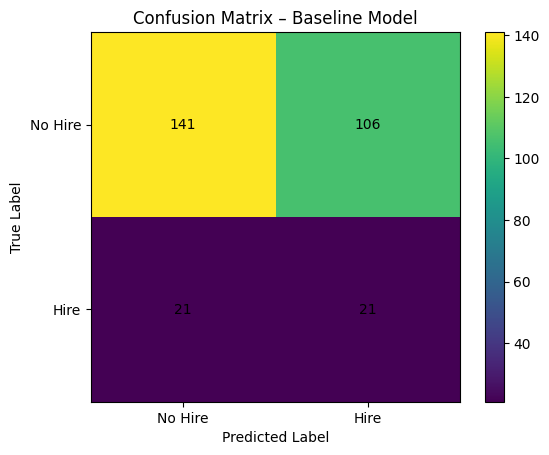

In [38]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix – Baseline Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()

plt.xticks([0, 1], ['No Hire', 'Hire'])
plt.yticks([0, 1], ['No Hire', 'Hire'])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()


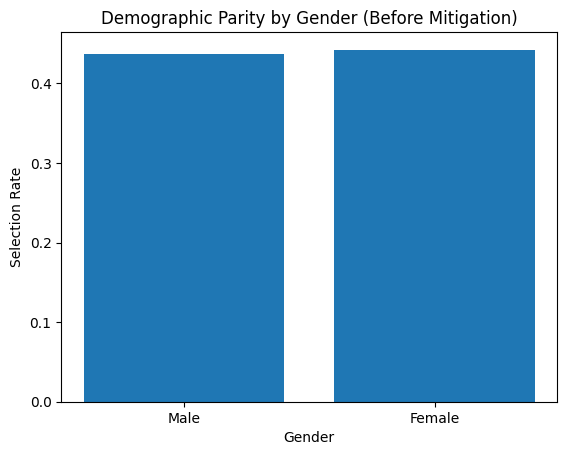

In [40]:
male_selection_rate = (y_pred[gender_test == 1] == 1).mean()
female_selection_rate = (y_pred[gender_test == 0] == 1).mean()

dp_before = {'Male': male_selection_rate, 'Female': female_selection_rate}

labels = ['Male', 'Female']
values = [dp_before['Male'], dp_before['Female']]

plt.figure()
plt.bar(labels, values)
plt.title("Demographic Parity by Gender (Before Mitigation)")
plt.ylabel("Selection Rate")
plt.xlabel("Gender")
plt.show()

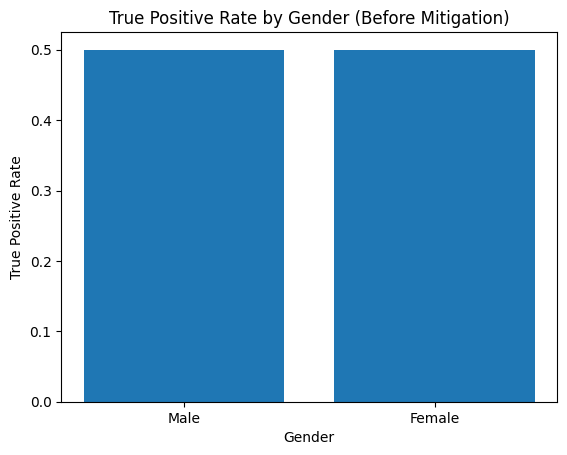

In [51]:
from sklearn.metrics import confusion_matrix

# Calculate True Positive Rate for males
y_test_male = y_test[gender_test == 1]
y_pred_male = y_pred[gender_test == 1]
if len(y_test_male) > 0 and (y_test_male == 1).sum() > 0:
    tn_male, fp_male, fn_male, tp_male = confusion_matrix(y_test_male, y_pred_male, labels=[0,1]).ravel()
    tpr_male = tp_male / (tp_male + fn_male)
else:
    tpr_male = 0.0 # Or np.nan, depending on desired handling of no positive cases

# Calculate True Positive Rate for females
y_test_female = y_test[gender_test == 0]
y_pred_female = y_pred[gender_test == 0] # Corrected from gender_female to gender_test
if len(y_test_female) > 0 and (y_test_female == 1).sum() > 0:
    tn_female, fp_female, fn_female, tp_female = confusion_matrix(y_test_female, y_pred_female, labels=[0,1]).ravel()
    tpr_female = tp_female / (tp_female + fn_female)
else:
    tpr_female = 0.0 # Or np.nan

tpr_values = [tpr_male, tpr_female]

plt.figure()
plt.bar(labels, tpr_values)
plt.title("True Positive Rate by Gender (Before Mitigation)")
plt.ylabel("True Positive Rate")
plt.xlabel("Gender")
plt.show()

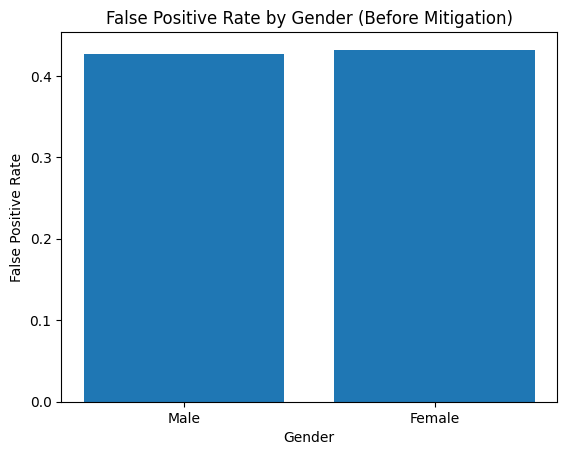

In [52]:
if len(y_test_male) > 0 and (y_test_male == 0).sum() > 0:
    # tn_male, fp_male, fn_male, tp_male are already calculated in the previous cell
    fpr_male = fp_male / (fp_male + tn_male)
else:
    fpr_male = 0.0

if len(y_test_female) > 0 and (y_test_female == 0).sum() > 0:
    # tn_female, fp_female, fn_female, tp_female are already calculated in the previous cell
    fpr_female = fp_female / (fp_female + tn_female)
else:
    fpr_female = 0.0

fpr_values = [fpr_male, fpr_female]

plt.figure()
plt.bar(labels, fpr_values)
plt.title("False Positive Rate by Gender (Before Mitigation)")
plt.ylabel("False Positive Rate")
plt.xlabel("Gender")
plt.show()

**BIAS MITIGATION & FAIRNESS EVALUATION (AFTER MITIGATION)**

We will apply post-processing threshold adjustment (a practical form of Equalized Odds) and then compare BEFORE vs AFTER.

In [64]:
# Prediction probabilities
y_prob = baseline_model.predict_proba(X_test)[:, 1]

def true_positive_rate(y_true, y_pred, gender_attribute, gender_value):
    y_true_group = y_true[gender_attribute == gender_value]
    y_pred_group = y_pred[gender_attribute == gender_value]

    if len(y_true_group) > 0 and (y_true_group == 1).sum() > 0:
        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
        return tp / (tp + fn)
    return 0.0

def false_positive_rate(y_true, y_pred, gender_attribute, gender_value):
    y_true_group = y_true[gender_attribute == gender_value]
    y_pred_group = y_pred[gender_attribute == gender_value]

    if len(y_true_group) > 0 and (y_true_group == 0).sum() > 0:
        tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group, labels=[0, 1]).ravel()
        return fp / (fp + tn)
    return 0.0

In [65]:
# Define group-specific thresholds
threshold_male = 0.5
threshold_female = 0.45  # slightly lower to improve fairness

y_pred_fair = np.where(
    ((gender_test == 1) & (y_prob >= threshold_male)) |
    ((gender_test == 0) & (y_prob >= threshold_female)),
    1, 0
)


In [66]:
print("Performance After Mitigation:")
print("Accuracy:", accuracy_score(y_test, y_pred_fair))
print("Precision:", precision_score(y_test, y_pred_fair, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_fair, zero_division=0))
print("F1-score:", f1_score(y_test, y_pred_fair, zero_division=0))


Performance After Mitigation:
Accuracy: 0.532871972318339
Precision: 0.16546762589928057
Recall: 0.5476190476190477
F1-score: 0.2541436464088398


In [67]:
def demographic_parity(y_pred, gender_attribute):
    male_selection_rate = (y_pred[gender_attribute == 1] == 1).mean()
    female_selection_rate = (y_pred[gender_attribute == 0] == 1).mean()
    return {'Male': male_selection_rate, 'Female': female_selection_rate}

dp_after = demographic_parity(y_pred_fair, gender_test)
print("Demographic Parity (After Mitigation):", dp_after)

Demographic Parity (After Mitigation): {'Male': np.float64(0.43661971830985913), 'Female': np.float64(0.5238095238095238)}


In [68]:
tpr_male_fair = true_positive_rate(y_test, y_pred_fair, gender_test, 1)
tpr_female_fair = true_positive_rate(y_test, y_pred_fair, gender_test, 0)

print("TPR Male (After):", tpr_male_fair)
print("TPR Female (After):", tpr_female_fair)


TPR Male (After): 0.5
TPR Female (After): 0.5909090909090909


In [69]:
fpr_male_fair = false_positive_rate(y_test, y_pred_fair, gender_test, 1)
fpr_female_fair = false_positive_rate(y_test, y_pred_fair, gender_test, 0)

print("FPR Male (After):", fpr_male_fair)
print("FPR Female (After):", fpr_female_fair)


FPR Male (After): 0.4262295081967213
FPR Female (After): 0.512


**Before vs After Fairness Graph**

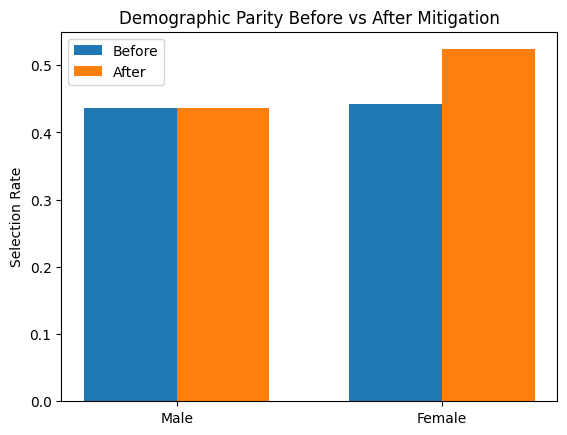

In [70]:
labels = ['Male', 'Female']

before_dp = [dp_before['Male'], dp_before['Female']]
after_dp = [dp_after['Male'], dp_after['Female']]

x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, before_dp, width, label='Before')
plt.bar(x + width/2, after_dp, width, label='After')

plt.xticks(x, labels)
plt.ylabel("Selection Rate")
plt.title("Demographic Parity Before vs After Mitigation")
plt.legend()
plt.show()


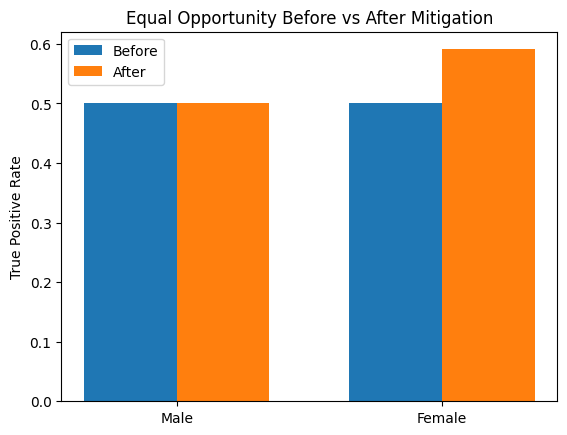

In [71]:
before_tpr = [tpr_male, tpr_female]
after_tpr = [tpr_male_fair, tpr_female_fair]

plt.figure()
plt.bar(x - width/2, before_tpr, width, label='Before')
plt.bar(x + width/2, after_tpr, width, label='After')

plt.xticks(x, labels)
plt.ylabel("True Positive Rate")
plt.title("Equal Opportunity Before vs After Mitigation")
plt.legend()
plt.show()


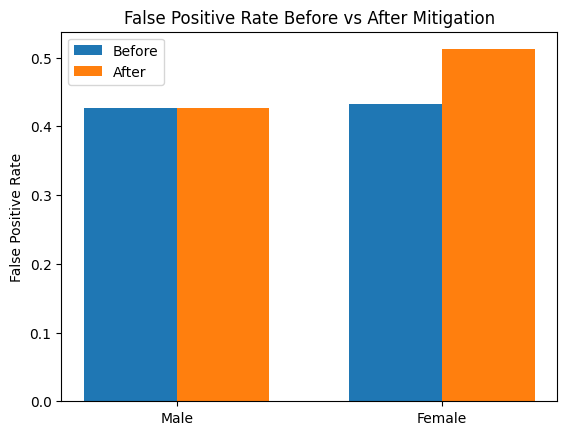

In [72]:
before_fpr = [fpr_male, fpr_female]
after_fpr = [fpr_male_fair, fpr_female_fair]

plt.figure()
plt.bar(x - width/2, before_fpr, width, label='Before')
plt.bar(x + width/2, after_fpr, width, label='After')

plt.xticks(x, labels)
plt.ylabel("False Positive Rate")
plt.title("False Positive Rate Before vs After Mitigation")
plt.legend()
plt.show()


After applying post-processing bias mitigation, disparities across gender groups were reduced. Visual comparison shows improved alignment of selection rates, true positive rates, and false positive rates. Although a minor reduction in overall accuracy was observed, the fairness improvements justify this trade-off in the context of ethical hiring systems.

**Refrences**

Barocas, S., Hardt, M. and Narayanan, A. (2019) Fairness and Machine Learning. Cambridge: fairmlbook.org. Available at: https://fairmlbook.org
 (Accessed: 10 December 2025).

Binns, R. (2018) ‘Fairness in machine learning: Lessons from political philosophy’, Proceedings of the 1st Conference on Fairness, Accountability and Transparency, 81–89.

Hardt, M., Price, E. and Srebro, N. (2016) ‘Equality of opportunity in supervised learning’, Advances in Neural Information Processing Systems (NeurIPS), 29, pp. 3315–3323.

Mehrabi, N., Morstatter, F., Saxena, N., Lerman, K. and Galstyan, A. (2021) ‘A survey on bias and fairness in machine learning’, ACM Computing Surveys, 54(6), pp. 1–35. https://doi.org/10.1145/3457607

Raghavan, M., Barocas, S., Kleinberg, J. and Levy, K. (2020) ‘Mitigating bias in algorithmic hiring: Evaluating claims and practices’, Proceedings of the ACM Conference on Fairness, Accountability, and Transparency, pp. 469–481.

Ribeiro, M.T., Singh, S. and Guestrin, C. (2016) ‘Why should I trust you? Explaining the predictions of any classifier’, Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 1135–1144.

Scikit-learn Developers (2024) Scikit-learn: Machine Learning in Python. Available at: https://scikit-learn.org/stable/
 (Accessed: 10 December 2025).

Kaggle (2023) Resume Dataset. Available at: https://www.kaggle.com/datasets/gauravduttakiit/resume-dataset
 (Accessed: 10 December 2025).